In [1]:
import pandas as pd
import numpy as np
import json
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot


In [2]:
# Replace with your file path
file_path = '../DataInputs/Weekly/amazon_weekly_close.json'

# Load JSON data from file
with open(file_path, 'r') as file:
    data = json.load(file)

# Convert data to pandas DataFrame
df = pd.DataFrame(list(data.items()), columns=['Date', 'Close'])
df['Date'] = pd.to_datetime(df['Date'])
df['Close'] = df['Close'].astype(float)
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)


In [5]:
# Split the data into training and test sets
train_df = df[df.index <= '2023-03-31']
# Assuming your data is weekly, select the next 12 weeks for the test set
short_test_df = df[df.index > train_df.index[-1]][:12]


# Check the last date in the training set and the first date in the test set
print("Last date in training set:", train_df.index[-1])
print("First date in test set:", short_test_df.index[0])

# Check the last few rows of the training set
print(train_df.tail())
df = train_df.copy()
# Check the first few rows of the test set
print(short_test_df.head())


Last date in training set: 2023-03-31 00:00:00
First date in test set: 2023-04-06 00:00:00
             Close
Date              
2023-03-03   94.90
2023-03-10   90.73
2023-03-17   98.95
2023-03-24   98.13
2023-03-31  103.29
              Close
Date               
2023-04-06  102.060
2023-04-14  102.510
2023-04-21  106.960
2023-04-28  105.450
2023-05-05  105.655


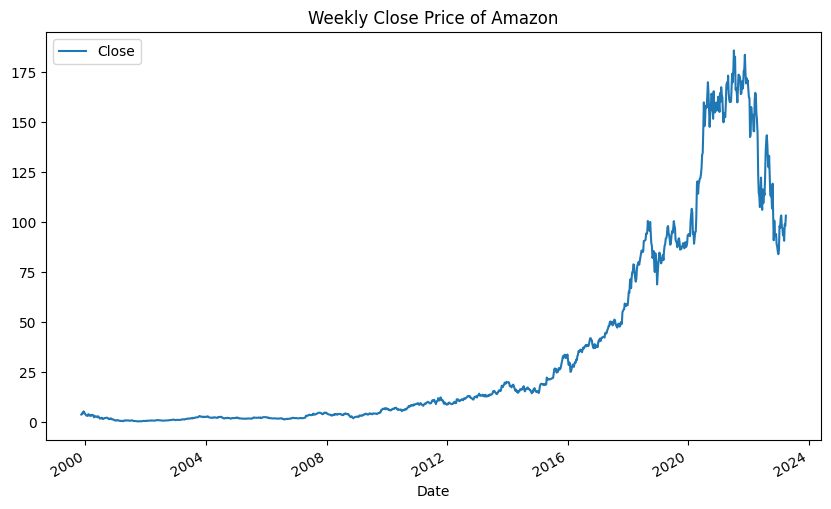

In [6]:
df.plot(figsize=(10,6))
plt.title('Weekly Close Price of Amazon')
plt.show()

In [7]:
result = adfuller(df['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# More detailed output can be shown, here we focus on p-value


ADF Statistic: -0.462745
p-value: 0.899084


In [8]:
# Assuming the series is not stationary, differencing is needed
df_diff = df.diff().dropna()

# Check stationarity again
result = adfuller(df_diff['Close'])
print('p-value after differencing: %f' % result[1])


p-value after differencing: 0.000000


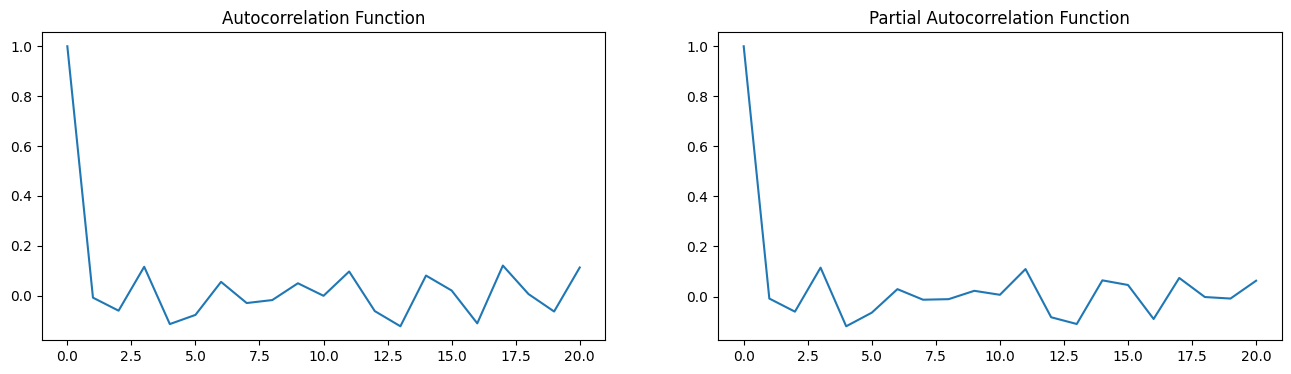

In [9]:
# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

# ACF
acf_values = acf(df_diff['Close'], nlags=20)
ax1.plot(acf_values)
ax1.set_title('Autocorrelation Function')

# PACF
pacf_values = pacf(df_diff['Close'], nlags=20)
ax2.plot(pacf_values)
ax2.set_title('Partial Autocorrelation Function')

plt.show()


In [10]:
# Replace p, d, q with your chosen values
model = ARIMA(df['Close'], order=(3,2,1))
results = model.fit()

# Summary of the model
print(results.summary())


c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1221
Model:                 ARIMA(3, 2, 1)   Log Likelihood               -2930.077
Date:                Sat, 13 Jan 2024   AIC                           5870.154
Time:                        17:45:11   BIC                           5895.683
Sample:                             0   HQIC                          5879.763
                               - 1221                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1      -9.355e-05      0.012     -0.008      0.994      -0.023       0.023
ar.L2         -0.0588      0.013     -4.669      0.000      -0.083      -0.034
ar.L3          0.1171      0.013      8.744      0.0

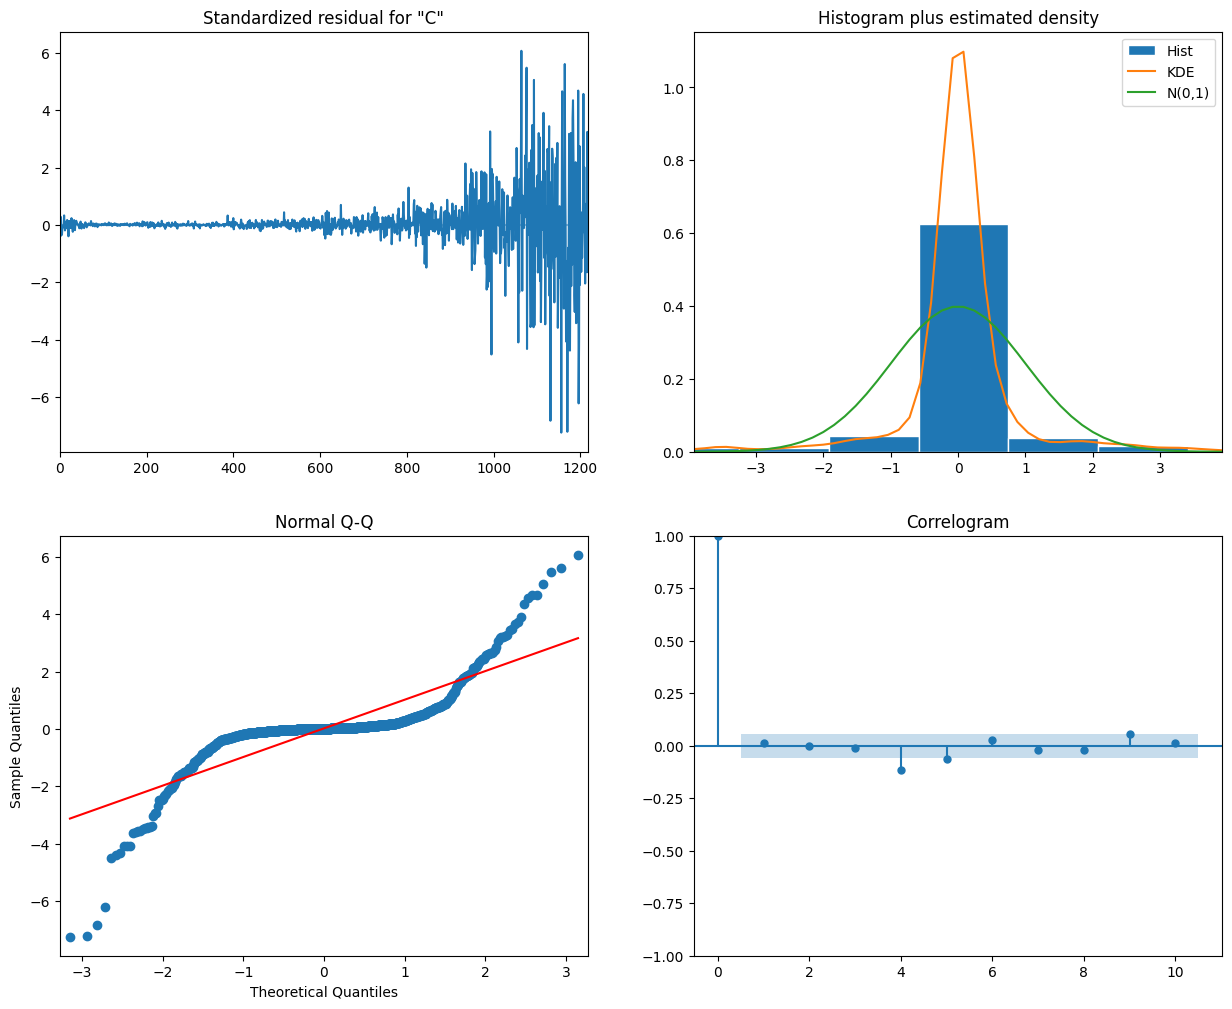

In [11]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()


c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


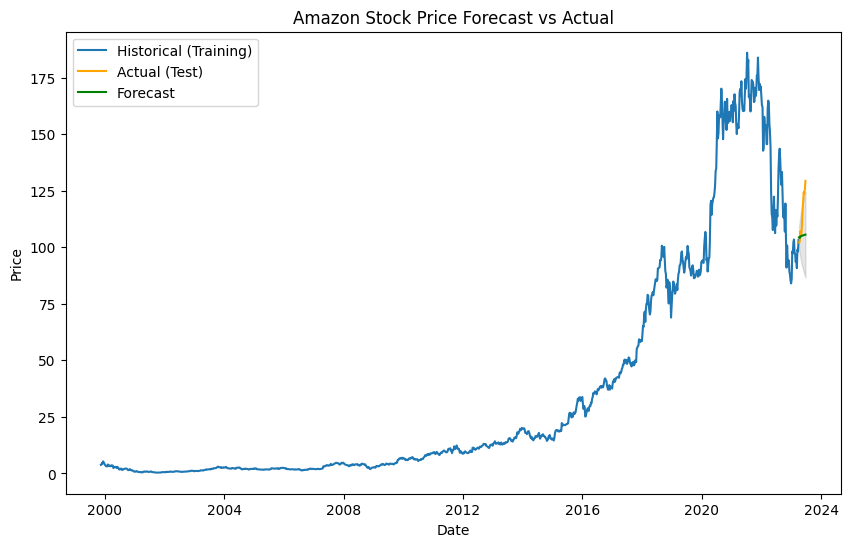

In [16]:
# Number of steps to forecast is the length of the test set
n_steps = len(short_test_df)

# Generate out-of-sample forecasts
forecast = results.get_forecast(steps=n_steps)
forecast_index = short_test_df.index  # Use the test set dates for the forecast index

# Confidence intervals
forecast_ci = forecast.conf_int()

# Plotting the forecast along with the test set
plt.figure(figsize=(10,6))
plt.plot(train_df.index, train_df['Close'], label='Historical (Training)')
plt.plot(short_test_df.index, short_test_df['Close'], label='Actual (Test)', color='orange')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecast', color='green')
plt.fill_between(forecast_index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], color='k', alpha=0.1)
plt.title('Amazon Stock Price Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

predicted_values = forecast.predicted_mean
actual_values = short_test_df['Close']

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print("Root Mean Squared Error: ", rmse)

# Calculate MAE
mae = mean_absolute_error(actual_values, predicted_values)
print("Mean Absolute Error: ", mae)


Root Mean Squared Error:  13.029263335537053
Mean Absolute Error:  9.95536337593943


trying to make it optimal


In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
# import pandas as pd

# # Assuming best_model is your trained SARIMAX model and test_df is your test set

# # Length of the test set
# n_steps = len(test_df)

# # Generating the forecast for n_steps
# forecast, conf_int = best_model.predict(n_steps=n_steps, return_conf_int=True)

# # Make sure the forecast_index aligns with the forecast length
# forecast_index = test_df.index[:len(forecast)]  # Adjust in case of length mismatch

# # Print the model summary
# print(best_model.summary())

# # Plotting the results
# plt.figure(figsize=(10,6))
# plt.plot(train_df.index, train_df['Close'], label='Historical (Training)', color='blue')
# plt.plot(test_df.index, test_df['Close'], label='Actual (Test)', color='orange')
# plt.plot(forecast_index, forecast, label='Forecast', color='green')

# # Fill the confidence interval
# plt.fill_between(forecast_index, 
#                  conf_int[:, 0], 
#                  conf_int[:, 1], color='grey', alpha=0.3)

# # Zoom in to the graph starting from July 2023
# plt.xlim([pd.Timestamp('2023-01-01'), forecast_index[-1]])

# # Set the title and labels
# plt.title('Optimized SARIMAX Forecast vs Actual')
# plt.xlabel('Date')
# plt.ylabel('Price')

# # Set the date format for the x-axis
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# # Rotate the date labels for better readability
# plt.gcf().autofmt_xdate()

# # Add the legend
# plt.legend()

# # Show the plot
# plt.show()


NameError: name 'best_model' is not defined

In [19]:
import pmdarima as pm

# Using auto_arima to find the best ARIMA model with a wider range of parameters
best_model = pm.auto_arima(train_df['Close'],
                           seasonal=True,  # assuming the data could be seasonal
                           m=52,           # weekly data, so m might be 52 for yearly seasonality
                           stepwise=True,
                           trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           max_p=5, max_q=5, max_d=2,
                           max_P=2, max_Q=2, max_D=1)

print(best_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=45.95 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=5881.955, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=5883.720, Time=6.21 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=5884.020, Time=7.14 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=5881.076, Time=0.04 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=5881.773, Time=3.54 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : AIC=5882.083, Time=4.17 sec
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AIC=5880.794, Time=8.55 sec
 ARIMA(0,1,0)(2,0,1)[52] intercept   : AIC=5877.257, Time=218.55 sec
 ARIMA(0,1,0)(2,0,0)[52] intercept   : AIC=5875.258, Time=45.52 sec
 ARIMA(1,1,0)(2,0,0)[52] intercept   : AIC=5877.192, Time=61.86 sec
 ARIMA(0,1,1)(2,0,0)[52] intercept   : AIC=5877.183, Time=56.63 sec
 ARIMA(1,1,1)(2,0,0)[52] intercept   : AIC=5878.067, Time=152.58 sec
 ARIMA(0,1,0)(2,0,0)[52]             : AIC=5874.153, Time=17.10 sec
 ARIMA(0,1,0)(1

c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


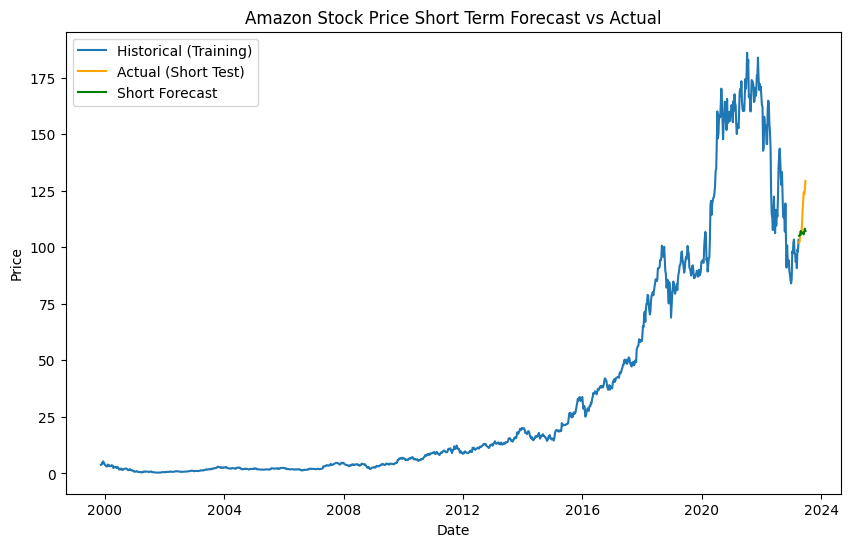

In [24]:
# Number of steps to forecast is now 12 (the length of the short_test_df)
short_n_steps = len(short_test_df)

# Generate out-of-sample forecasts for 12 weeks
short_forecast = best_model.predict(n_periods=short_n_steps)
short_forecast_index = short_test_df.index

# Plotting the shortened forecast along with the corresponding test set
plt.figure(figsize=(10,6))
plt.plot(train_df.index, train_df['Close'], label='Historical (Training)')
plt.plot(short_test_df.index, short_test_df['Close'], label='Actual (Short Test)', color='orange')
plt.plot(short_forecast_index, short_forecast, label='Short Forecast', color='green')
plt.title('Amazon Stock Price Short Term Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


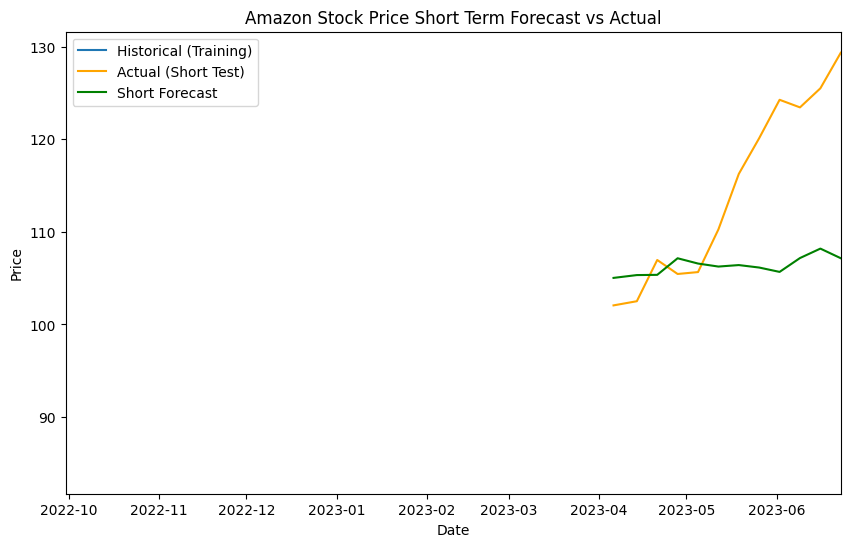

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming train_df, short_test_df, and best_model are already defined

# Calculate the date range for the plot
plot_start_date = train_df.index[-1] - pd.DateOffset(months=6)  # 6 months before the last training date
plot_end_date = short_test_df.index[-1] # End date of the short forecast

short_n_steps = len(short_test_df)

short_forecast = best_model.predict(n_periods=short_n_steps)
short_forecast_index = short_test_df.index

plt.figure(figsize=(10,6))
plt.plot(train_df[plot_start_date:], train_df['Close'][plot_start_date:], label='Historical (Training)')
plt.plot(short_test_df.index, short_test_df['Close'], label='Actual (Short Test)', color='orange')
plt.plot(short_forecast_index, short_forecast, label='Short Forecast', color='green')
plt.xlim([plot_start_date, plot_end_date]) # Set the x-axis limits
plt.title('Amazon Stock Price Short Term Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [38]:
# Check the indices of both series
print("Indices of short_test_df['Close']:", short_test_df['Close'].index)
print("Indices of short_forecast_series:", short_forecast_series.index)

# Handle NaNs in short_forecast_series by filling with a value (e.g., mean of the series)
filled_forecast_series = short_forecast_series.fillna(short_forecast_series.mean())

# It's crucial to ensure the indices match before calculating RMSE and MAE
# You might need to adjust this step based on how your indices are structured
aligned_test_df = short_test_df['Close'][filled_forecast_series.index]

# Recompute RMSE and MAE
short_rmse = np.sqrt(mean_squared_error(aligned_test_df, filled_forecast_series))
short_mae = mean_absolute_error(aligned_test_df, filled_forecast_series)

print("12-Week Forecast Root Mean Squared Error:", short_rmse)
print("12-Week Forecast Mean Absolute Error:", short_mae)


Indices of short_test_df['Close']: DatetimeIndex(['2023-04-06', '2023-04-14', '2023-04-21', '2023-04-28',
               '2023-05-05', '2023-05-12', '2023-05-19', '2023-05-26',
               '2023-06-02', '2023-06-09', '2023-06-16', '2023-06-23'],
              dtype='datetime64[ns]', name='Date', freq=None)
Indices of short_forecast_series: DatetimeIndex(['2023-04-06', '2023-04-14', '2023-04-21', '2023-04-28',
               '2023-05-05', '2023-05-12', '2023-05-19', '2023-05-26',
               '2023-06-02', '2023-06-09', '2023-06-16', '2023-06-23'],
              dtype='datetime64[ns]', name='Date', freq=None)


ValueError: Input contains NaN.

brute force the best modal with best rsme and mae


In [ ]:
import warnings
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Suppress warnings
warnings.filterwarnings("ignore")

# Set frequency of the date index
train_df.index = pd.DatetimeIndex(train_df.index.values, freq=train_df.index.inferred_freq)
test_df.index = pd.DatetimeIndex(test_df.index.values, freq=test_df.index.inferred_freq)

# Define the range of parameters
p = d = q = range(0, 4)
P = D = Q = range(0, 3)
m = 52  # assuming weekly seasonality

best_rmse, best_mae, best_cfg = float("inf"), float("inf"), None
iteration = 1

# Iterate over all combinations
for order in itertools.product(p, d, q):
    for seasonal_order in itertools.product(P, D, Q):
        try:
            # Fit model
            model = SARIMAX(train_df['Close'], order=order, seasonal_order=(seasonal_order[0], seasonal_order[1], seasonal_order[2], m))
            model_fit = model.fit(disp=False)
            
            # Make prediction
            forecast = model_fit.forecast(steps=len(test_df))
            
            # Evaluate the model
            rmse = np.sqrt(mean_squared_error(test_df['Close'], forecast))
            mae = mean_absolute_error(test_df['Close'], forecast)
            
            # Compare with the best score
            if rmse < best_rmse and mae < best_mae:
                best_rmse, best_mae, best_cfg = rmse, mae, order + seasonal_order
                print(f"{iteration}. New best SARIMA: {best_cfg}, RMSE: {best_rmse}, MAE: {best_mae}")
            iteration += 1
        except Exception as e:
            print(f"Error in iteration {iteration}: {e}")
            continue

print(f'Best SARIMA: {best_cfg}, RMSE: {best_rmse}, MAE: {best_mae}')


1. New best SARIMA: (0, 0, 0, 0, 0, 0), RMSE: 130.75554764381565, MAE: 129.98231707317072
2. New best SARIMA: (0, 0, 0, 0, 0, 1), RMSE: 88.77308630959784, MAE: 82.6387054069923
4. New best SARIMA: (0, 0, 0, 0, 1, 0), RMSE: 32.9783655152113, MAE: 25.211548780487803
8. New best SARIMA: (0, 0, 0, 0, 2, 1), RMSE: 31.725582694576175, MAE: 23.939613446440458
